In [2]:
import pandas as pd 
import numpy as np
import scipy
from scipy.stats import gamma
import matplotlib.pyplot as plt
import seaborn as sns

import joblib
import os
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from lightgbm import LGBMClassifier
from features import get_feature_columns_for_healthscore
from sklearn.metrics import *
from sklearn.calibration import calibration_curve, CalibrationDisplay, CalibratedClassifierCV
from sklearn.model_selection import KFold, cross_validate
from sklearn.decomposition import PCA
from sklearn.compose import make_column_transformer 
from sklearn.compose import make_column_selector as selector
from sklearn.ensemble import (
    RandomForestClassifier, ExtraTreesClassifier
)

import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms
from matplotlib.gridspec import GridSpec

from data import (
    data_dir, project_dir, model_dir
)

from datetime import datetime
import warnings, os, shutil
warnings.filterwarnings(action='ignore') 

sns.set(color_codes=True)
sns.set(rc={'figure.figsize':(5,5)})


In [3]:
## constants
np.random.seed(369)
rs = 369
k = 3
cp_bins = 30

score_types = ['M', 'F']
algorithms = ['logistic',]# 'LGBM', 'RF']
models = [
    LogisticRegression(class_weight='balanced', max_iter=2000),
    # LGBMClassifier(class_weight='balanced', importance_type='gain'),
    # RandomForestClassifier(class_weight='balanced', n_estimators=1000),
]

In [4]:
# plot hist
def plot_prob_dist(y_score, title):
    prob_dist = (1 - y_score) * 1000
    print(pd.DataFrame(prob_dist, columns = ['score']).describe())

    fig, ax = plt.subplots(figsize=(6,6))
    ax = sns.distplot(
        prob_dist, 
        kde=False,
        hist=True,
        bins=cp_bins,
        color='blue',
        # hist_kws={"linewidth": 15,'alpha':1}
        )
    ax.set(
        xlabel='(1-predict_proba)*1000', 
        ylabel='Frequency', 
        title = title, 
        # xlim = (0,1000)
        )
    plt.show()

In [5]:
c_df = pd.read_pickle(
    os.path.join(data_dir, 'processed', 'Healthscore_features.pkl'))

In [8]:
c_df.AGE.describe()

count    213011.000000
mean         58.411814
std           8.965927
min          47.000000
25%          51.000000
50%          56.000000
75%          64.000000
max          90.000000
Name: AGE, dtype: float64

<AxesSubplot: ylabel='Frequency'>

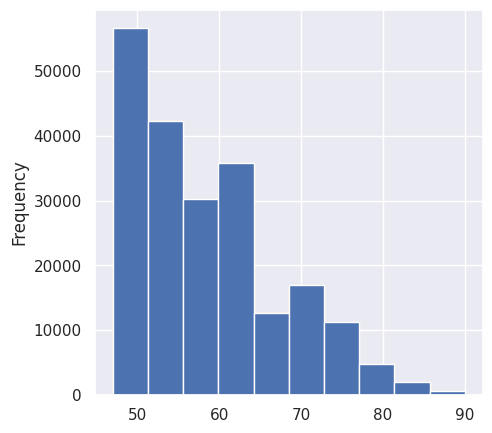

In [9]:
c_df.AGE.plot(kind='hist')

In [10]:
del c_df

In [11]:
model = LogisticRegression(class_weight='balanced', max_iter=2000)
imputer = SimpleImputer(strategy='median')
og_df = pd.read_pickle(
    os.path.join(data_dir, 'processed', 'Healthscore_features.pkl'))
target_column = 'Death_EVENT'


In [12]:
# check prevalence
for score_type in score_types:
    print(score_type)
    df = og_df
    if score_type=='M':
        df = df[df['SEX']==1]
    elif score_type=='F':
        df = df[df['SEX']==2]

    alive, dead = df.Death_EVENT.value_counts()
    print('alive, dead', alive, dead)
    death_rate = dead / (alive + dead)
    print('Prevalence (death rate):', round(death_rate,4))

M
alive, dead 112029 6277
Prevalence (death rate): 0.0531
F
alive, dead 92003 2702
Prevalence (death rate): 0.0285


In [13]:
age_ranges = [[40.0,49.0], [50.0,59.0], [60.0,69.0], [70.0,79.0], [80.0,89.0], [90.0,99.0]]

In [18]:
# get score per age range
for score_type in score_types:
    for min_age, max_age in age_ranges:
        print('age range', min_age, max_age)
        print('df shape before age cut', og_df.shape)
        df = og_df[(og_df['AGE']>=min_age) & (og_df['AGE'] <=max_age)].copy()
        print('df shape after age cut', df.shape)
        init_cnt = df.shape[0]
        
        if init_cnt == 0:
            print('no rows for age range', init_cnt)
            continue

        if score_type=='M':
            df = df[df['SEX']==1]
            np.random.seed(2020)
            pids = df['PERSON_ID'].unique()
            test_pids_man = np.random.choice(pids, size=int(len(pids) * 0.2))
            test_mask_man = np.in1d(df['PERSON_ID'], test_pids_man)
            test_pids = test_pids_man
            test_mask = test_mask_man
        elif score_type=='F':
            df = df[df['SEX']==2]
            np.random.seed(2020)
            pids = df['PERSON_ID'].unique()
            test_pids_woman = np.random.choice(pids, size=int(len(pids) * 0.2))
            test_mask_woman = np.in1d(df['PERSON_ID'], test_pids_woman)
            test_pids = test_pids_woman
            test_mask = test_mask_woman

        screen_features, family_past_features, habbitual_features = get_feature_columns_for_healthscore(score_type)
        feature_columns = screen_features+family_past_features+habbitual_features
        
        multi_col = ['METs', 'TM1_DRKQTY_RSPS_CD']
        for col in multi_col:
            df[col+'^2'] = df[col]*df[col]
        t_df = df.copy()
        t_df.loc[:, feature_columns] = imputer.fit_transform(df[feature_columns])

        print('Training healthscore model for {}'.format(score_type))
        
        selected_features = screen_features+family_past_features+habbitual_features+ ['METs^2', 'TM1_DRKQTY_RSPS_CD^2']
        print('Using basic + past,family features + habitual features + 2 squared features')
        std = df.loc[~test_mask, selected_features].std()
        mean = df.loc[~test_mask, selected_features].mean()
        df[selected_features] = (df[selected_features]-mean)/std
        break
        # model
        data = df
        train_df, test_df = data[~test_mask], data[test_mask]
        try:
            model.fit(train_df[selected_features], train_df[target_column])
        except:
            print('Less than 2 classes available for given age range!')
            continue

        y_score = model.predict_proba(test_df[selected_features])[:, 1]
        y_pred = np.array(y_score > 0.5, dtype=np.int32)
        y_true = np.array(test_df[target_column], dtype=np.int32)

        roc_auc_ = roc_auc_score(test_df[target_column], y_score)
        apr_ = average_precision_score(test_df[target_column], y_score)
        name = 'logistic'
        print('AUROC score for {} model: {}'. format(name, round(roc_auc_, 4)))
        print('AUPRC score for {} model: {}'. format(name, round(apr_, 4)))
        print()

        title='Score Distribution (Sex={}, Ages={}~{}, Cnt={})'.format(
            score_type, min_age, max_age, init_cnt)
        plot_prob_dist(y_score, title)
        print()

age range 40.0 49.0
df shape before age cut (213011, 44)
df shape after age cut (33813, 44)
Training healthscore model for M
Using basic + past,family features + habitual features + 2 squared features
age range 40.0 49.0
df shape before age cut (213011, 44)
df shape after age cut (33813, 44)
Training healthscore model for F
Using basic + past,family features + habitual features + 2 squared features


In [19]:
df[selected_features].head()

,BMI,BP_HIGH,BP_LWST,BLDS,TOT_CHOLE,TRIGLYCERIDE,HDL_CHOLE,LDL_CHOLE,HMG,OLIG_PROTE_CD,...,FMLY_CANCER_PATIEN_YN,SMK_STAT_TYPE_RSPS_CD,SMK_TERM_RSPS_CD,PAST_DSQTY_RSPS_CD,CUR_DSQTY_RSPS_CD,DRNK_HABIT_RSPS_CD,TM1_DRKQTY_RSPS_CD,METs,METs^2,TM1_DRKQTY_RSPS_CD^2
882245,-0.836518,-0.588815,-0.419329,-0.471651,-1.387659,-0.338755,-0.670207,-0.736983,-0.463914,-0.185008,...,-0.371762,-0.139114,-0.12063,-0.065644,-0.096485,0.68733,0.441241,-0.100251,-0.275197,-0.032845
882250,1.769287,-0.588815,-0.419329,-0.360923,-0.286610,-0.975261,-0.704110,0.603594,-2.443462,-0.185008,...,-0.371762,-0.139114,-0.12063,-0.065644,-0.096485,-0.43018,-0.408654,-0.542845,-0.515538,-0.318344
882264,-0.146114,0.122995,0.614155,-0.693109,-0.230146,-0.235138,0.007856,-0.178410,0.485651,-0.185008,...,-0.371762,-0.139114,-0.12063,-0.065644,-0.096485,-0.43018,0.441241,-0.401137,-0.447515,-0.032845
882272,-1.047400,-0.588815,-1.452812,-0.084101,1.068527,-0.353558,0.618112,0.631523,1.198598,-0.185008,...,2.689626,-0.139114,-0.12063,-0.065644,-0.096485,-0.43018,-0.408654,-0.606905,-0.543528,-0.318344
882413,-0.183723,-0.588815,-0.419329,0.248085,0.362727,0.179331,-0.161660,0.380164,0.010869,-0.185008,...,-0.371762,-0.139114,-0.12063,-0.065644,-0.096485,-0.43018,-0.743964,-0.944674,-0.662695,-0.343183
